In [1]:
!pip install yfinance
!pip install GetOldTweets3
!pip install treeinterpreter

In [2]:
import datetime
import GetOldTweets3 as got
import yfinance as yf
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import csv

In [3]:
import sys
import re
import string
import json
import os

In [4]:
import nltk
nltk.download('vader_lexicon')
nltk.download('wordnet')
nltk.download('stopwords')
nltk.download('punkt')
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

from nltk.sentiment.vader import SentimentIntensityAnalyzer
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import unicodedata
sentiment_i_a = SentimentIntensityAnalyzer()

from nltk.corpus import subjectivity
from nltk.sentiment import SentimentAnalyzer
from nltk.sentiment.util import *

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\ym\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\ym\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping corpora\wordnet.zip.
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\ym\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping corpora\stopwords.zip.
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\ym\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [5]:
from sklearn.model_selection import train_test_split
from treeinterpreter import treeinterpreter as ti
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor

from sklearn import svm
from sklearn.svm import SVR 

from sklearn.metrics import mean_squared_error
from math import sqrt


In [6]:
#Get stock data for the given Stock Name
def getStockDetails(stockname,start_time,end_time):
  company = yf.Ticker(stockname)
  company.info.get("longName")
  stockData = yf.download(stockname, start=start_time, end=end_time)
  print("\n Stock Data Obtained ")
  print(stockData.head())
  print("\n")
  plt.title('Time series chart of Closing stocks for ' + company.info.get("longName"))
  plt.plot(stockData["Close"])
  plt.show()
  print("\n")
  stockData.to_csv('stockData_' + stockname + '.csv')

In [7]:
#Method for data cleaning
class TweetCleaner:
    def __init__(self):
        self.stop_words = set(stopwords.words('english'))
        self.punc_table = str.maketrans("", "", string.punctuation) # to remove punctuation from each word in tokenize

    def compound_word_split(self, compound_word):
        matches = re.finditer('.+?(?:(?<=[a-z])(?=[A-Z])|(?<=[A-Z])(?=[A-Z][a-z])|$)', compound_word)
        return [m.group(0) for m in matches]

    def remove_non_ascii_chars(self, text):
        return ''.join([w if ord(w) < 128 else ' ' for w in text])

    def remove_hyperlinks(self,text):
        return ' '.join([w for w in text.split(' ')  if not 'http' in w])

    def get_cleaned_text(self, text):
        cleaned_tweet = text.replace('\"','').replace('\'','').replace('-',' ')
        cleaned_tweet =  self.remove_non_ascii_chars(cleaned_tweet)
        if re.match(r'RT @[_A-Za-z0-9]+:',cleaned_tweet):
            cleaned_tweet = cleaned_tweet[cleaned_tweet.index(':')+2:]
        cleaned_tweet = self.remove_hyperlinks(cleaned_tweet)
        cleaned_tweet = cleaned_tweet.replace('#','HASHTAGSYMBOL').replace('@','ATSYMBOL') # to avoid being removed while removing punctuations
        tokens = [w.translate(self.punc_table) for w in word_tokenize(cleaned_tweet)] # remove punctuations and tokenize
        tokens = [nltk.WordNetLemmatizer().lemmatize(w) for w in tokens if not w.lower() in self.stop_words and len(w)>1] # remove stopwords and single length words
        cleaned_tweet = ' '.join(tokens)
        cleaned_tweet = cleaned_tweet.replace('HASHTAGSYMBOL','#').replace('ATSYMBOL','@')
        cleaned_tweet = cleaned_tweet
        return cleaned_tweet

    def clean_tweets(self, tweets, is_bytes = False):   
        test_tweet_list = []
        for tweet in tweets:
            if is_bytes:
                test_tweet_list.append(self.get_cleaned_text(ast.literal_eval(tweet).decode("UTF-8")))
            else:
                test_tweet_list.append(self.get_cleaned_text(tweet))
        return test_tweet_list
    
    def clean_single_tweet(self, tweet, is_bytes = False):  
        if is_bytes:
             return self.get_cleaned_text(ast.literal_eval(tweet).decode("UTF-8"))
        return self.get_cleaned_text(tweet)
    
    def cleaned_file_creator(self, op_file_name, value1, value2):
        csvFile = open(op_file_name, 'w+')
        csvWriter = csv.writer(csvFile)
        for tweet in range(len(value1)):
            csvWriter.writerow([value1[tweet], value2[tweet]])
        csvFile.close()

In [8]:
#Method for fetching tweets
def fetchTweets(stockname,start_time,end_time):
  csvFile = open('tweets_' + stockname + '.csv', 'a',encoding="utf-8")
  csvWriter = csv.writer(csvFile, lineterminator= '\n')
  cleanObj = TweetCleaner()
  
  tweetCriteria = got.manager.TweetCriteria().setQuerySearch(stockname).setSince(start_time).setUntil(end_time).setTopTweets("true") 
  tweets = got.manager.TweetManager.getTweets(tweetCriteria)
  try:
    for tweet in tweets:
      tweet_text = tweet.text.encode('utf-8')
      tweet_text = cleanObj.get_cleaned_text(tweet_text.decode())
      tweetDate = tweet.date.date()
      csvWriter.writerow([tweetDate, tweet.text])
  except BaseException as e:
      print('failed on_status,',str(e))


In [9]:
#Method for processing tweets
def processTweets(stockname):
  columns=['Date','Tweets']
  data = pd.DataFrame(columns)
  df = pd.read_csv('tweets_' + stockname  + '.csv',encoding='utf-8', names=columns, header=None)
  
  indx=0
  get_tweet=""
  #get tweets day wise
  for i in range(0,len(df)-1):
    get_date=df.Date.iloc[i]
    next_date=df.Date.iloc[i+1]
    if(str(get_date)==str(next_date)):
      get_tweet = get_tweet + df.Tweets.iloc[i]+" "
    if(str(get_date)!=str(next_date)):
      data.at[indx,'Date'] = get_date
      data.at[indx,'Tweets'] = get_tweet
      indx=indx+1
      get_tweet=" "

  #get respective prices for each day using stockData
  data['Prices']=""
  readStockData = pd.read_csv('stockData_' + stockname + '.csv')
  readStockData.columns = [c.replace(' ', '_') for c in readStockData.columns]
  for i in range (0,len(data)):
      for j in range (0,len(readStockData)):
          get_tweet_date = data.Date.iloc[i]
          get_stock_date = readStockData.Date.iloc[j]
          if(str(get_stock_date)==str(get_tweet_date)):
            data.at[i,'Prices'] = int(readStockData.Adj_Close[j])
            break

  #drop rows that do not have Price values
  data['Prices'].replace('', np.nan, inplace=True)
  data.dropna(subset=['Prices'], inplace=True)
  data.reset_index(drop=True, inplace=True)
  data['Prices'] = data['Prices'].apply(np.int64)
  data.drop(0, 1, inplace=True)
  print(data.head())
  data.to_csv('processedTweets_' + stockname  + '.csv')


In [10]:
#Method for sentiment analysis for tweets
def sentimentAnalysis(stockname):
  data = pd.read_csv('processedTweets_' + stockname  + '.csv', encoding='utf-8')
  data["Comp"] = ''
  data["Negative"] = ''
  data["Neutral"] = ''
  data["Positive"] = ''
  for indexx, row in data.T.iteritems():
    try:
      sentence_i = unicodedata.normalize('NFKD', data.loc[indexx, 'Tweets'])
      sentence_sentiment = sentiment_i_a.polarity_scores(sentence_i)
      data.at[indexx, 'Comp'] =  sentence_sentiment['compound']
      data.at[indexx, 'Negative'] = sentence_sentiment['neg']
      data.at[indexx, 'Neutral'] =  sentence_sentiment['neu']
      data.at[indexx, 'Positive'] = sentence_sentiment['pos'] 
    except TypeError:
      print('failed on_status,',str(e))

  data.drop(['Unnamed: 0'], 1, inplace=True)
  print(data.head())
  data.to_csv('sentimentAnalysis_' + stockname  + '.csv')

  posi=0
  nega=0
  neutral = 0
  for i in range (0,len(data)):
    get_val = data.Comp[i]
    if(float(get_val)<(0)):
        nega=nega+1
    if(float(get_val>(0))):
        posi=posi+1
    if(float(get_val)==(0)):
        neutral=neutral+1
  
  posper=(posi/(len(data)))*100
  negper=(nega/(len(data)))*100
  neutralper=(neutral/(len(data)))*100

  arr=np.asarray([posper,negper,neutralper], dtype=int)
  plt.figure()
  plt.pie(arr,labels=['positive','negative', 'neutral'])
  plt.plot()

  print("% of positive tweets= ",posper)
  print("% of negative tweets= ",negper)
  print("% of neutral tweets= ",neutralper)
  

In [11]:
#Method for stock price prediction using random forest model
def RandomForestModel(stockname):
  df = pd.read_csv('sentimentAnalysis_' + stockname  + '.csv', encoding='utf-8')
  train, test = train_test_split(df, shuffle=False, test_size=0.2)

  sentiment_score_list_train = []
  for date, row in train.T.iteritems():
    sentiment_score = np.asarray([df.loc[date, 'Negative'],  df.loc[date, 'Neutral'], df.loc[date, 'Positive']])
    sentiment_score_list_train.append(sentiment_score)
  numpy_df_train = np.asarray(sentiment_score_list_train)

  sentiment_score_list_test = []
  for date, row in test.T.iteritems():
    sentiment_score = np.asarray([df.loc[date, 'Negative'],  df.loc[date, 'Neutral'], df.loc[date, 'Positive']])
    sentiment_score_list_test.append(sentiment_score)
  numpy_df_test = np.asarray(sentiment_score_list_test)

  y_train = pd.DataFrame(train['Prices'])
  y_test = pd.DataFrame(test['Prices'])

  rf = RandomForestRegressor()
  rf.fit(numpy_df_train, y_train)
  prediction, bias, contributions = ti.predict(rf, numpy_df_test)

  print("\n\n")
  plt.figure()
  plt.plot(test['Prices'].iloc[:].values)
  plt.plot(prediction.flatten())
  plt.title('Random Forest predicted prices')
  plt.ylabel('Stock Prices')
  plt.xlabel('Days')
  plt.legend(['actual', 'predicted'])
  plt.show()

  print("\n\n")
  print("RMSE value for Random Forest Model : ")
  rmse = sqrt(mean_squared_error(y_test, prediction.flatten()))
  print(rmse)
  print("\n\n")


In [12]:
#Method for stock price prediction using support vector regression model
def SVRModel(stockname):
  df = pd.read_csv('sentimentAnalysis_' + stockname  + '.csv', encoding='utf-8')
  train, test = train_test_split(df, shuffle=False, test_size=0.2)

  sentiment_score_list_train = []
  for date, row in train.T.iteritems():
    sentiment_score = np.asarray([df.loc[date, 'Negative'],  df.loc[date, 'Neutral'], df.loc[date, 'Positive']])
    sentiment_score_list_train.append(sentiment_score)
  numpy_df_train = np.asarray(sentiment_score_list_train)

  sentiment_score_list_test = []
  for date, row in test.T.iteritems():
    sentiment_score = np.asarray([df.loc[date, 'Negative'],  df.loc[date, 'Neutral'], df.loc[date, 'Positive']])
    sentiment_score_list_test.append(sentiment_score)
  numpy_df_test = np.asarray(sentiment_score_list_test)

  y_train = pd.DataFrame(train['Prices'])
  y_test = pd.DataFrame(test['Prices'])

  svr_rbf = SVR(kernel='rbf', C=1e6, gamma=0.1)
  svr_rbf.fit(numpy_df_train, y_train.values.flatten())
  output_test_svm = svr_rbf.predict(numpy_df_test)

  plt.figure()
  plt.plot(test['Prices'].iloc[:].values)
  plt.plot(output_test_svm)
  plt.title('SVM predicted prices')
  plt.ylabel('Stock Prices')
  plt.xlabel('Days')
  plt.legend(['actual', 'predicted'])
  plt.show()

  print("\n\n")
  print("RMSE value for Support Vector Regression Model : ")
  rmse = sqrt(mean_squared_error(y_test, output_test_svm))
  print(rmse)
  print("\n\n")


Enter a valid STOCKNAME of the Corporation: AAPL
Enter the Start Date in the following format[YYYY-MM-DD]: 2020-01-01
Enter the End Date in the following format[YYYY-MM-DD]: 2020-12-31
------------------------------ Getting Stock details -----------------------------
[*********************100%***********************]  1 of 1 completed

 Stock Data Obtained 
                 Open       High        Low      Close  Adj Close     Volume
Date                                                                        
2019-12-31  72.482498  73.419998  72.379997  73.412498  72.337982  100805600
2020-01-02  74.059998  75.150002  73.797501  75.087502  73.988480  135480400
2020-01-03  74.287498  75.144997  74.125000  74.357498  73.269165  146322800
2020-01-06  73.447502  74.989998  73.187500  74.949997  73.852982  118387200
2020-01-07  74.959999  75.224998  74.370003  74.597504  73.505653  108872000




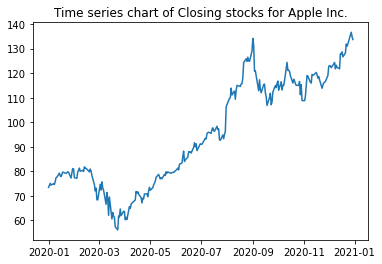



Stock Details fetched! 

------------------------------ Fetching Tweets -----------------------------


ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



An error occured during an HTTP request: HTTP Error 404: Not Found
Try to open in browser: https://twitter.com/search?q=AAPL%20since%3A2020-01-01%20until%3A2020-12-31&src=typd
Traceback (most recent call last):
  File "C:\Users\ym\anaconda3\lib\site-packages\GetOldTweets3\manager\TweetManager.py", line 343, in getJsonResponse
    response = opener.open(url)
  File "C:\Users\ym\anaconda3\lib\urllib\request.py", line 523, in open
    response = meth(req, response)
  File "C:\Users\ym\anaconda3\lib\urllib\request.py", line 632, in http_response
    response = self.parent.error(
  File "C:\Users\ym\anaconda3\lib\urllib\request.py", line 561, in error
    return self._call_chain(*args)
  File "C:\Users\ym\anaconda3\lib\urllib\request.py", line 494, in _call_chain
    result = func(*args)
  File "C:\Users\ym\anaconda3\lib\urllib\request.py", line 641, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 404: Not Found

During handlin

TypeError: object of type 'NoneType' has no len()

In [14]:
def main():
  name = input("Enter a valid STOCKNAME of the Corporation: ") #enter the name of the company
  start_date = input("Enter the Start Date in the following format[YYYY-MM-DD]: ") #enter the start date to fetch the tweets
  end_date = input("Enter the End Date in the following format[YYYY-MM-DD]: " ) #enter the end date to fetch the tweets
  
  if(len(name) > 0):
    STOCKNAME  = name
  else:
    STOCKNAME = "AAPL"
  
  if(len(start_date) > 0):
    start_time = start_date
  else:
    start_time = "2018-01-01"
  
  if(len(end_date) > 0):
    end_time = end_date
  else:
    end_time = "2019-12-31"


  #Get Stock Details
  print("------------------------------ Getting Stock details -----------------------------")
  stockData = getStockDetails(STOCKNAME,start_time,end_time)
  print("Stock Details fetched! \n")

  #Fetching tweets
  print("------------------------------ Fetching Tweets -----------------------------")
  fetchTweets(STOCKNAME,start_time,end_time)
  print("Tweets fetched! \n")

  #Get tweets Per Day and get the stock closing values for each date
  print("------------------------------ Processing Tweets -----------------------------")
  processTweets(STOCKNAME)
  print("Processed Tweets ! \n")

  #Perform Sentiment Analysis
  print("------------------------------ Performing Sentiment Analysis -----------------------------")
  sentimentAnalysis(STOCKNAME)
  print("Completed Sentiment Analysis on Tweets ! \n\n")
  #time.sleep(10);

  #Training and Predicting using Random Forest Regression Model
  print("--------  Training and Predicting using Random Forest Regression Model -------")
  RandomForestModel(STOCKNAME)
  print("\n \n")

  #Training and Predicting using Support Vecor Regression Model
  print("-------- Training and Predicting using Support Vector Regression Model ------------")
  SVRModel(STOCKNAME)
  print("\n \n")

main()